In [1]:
# Import libraries

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import networkx as nx
import community as community_louvain



In [2]:
# Load Comments
comments = pd.read_csv("data/filtered_comments.csv")

# Load Users
users = pd.read_csv("data/filtered_users.csv")

# Load Following
following = pd.read_csv("data/filtered_following.csv")

# Load Likes
likes = pd.read_csv("data/filtered_likes.csv")

# Load Entries/Posts
entries = pd.read_csv("data/filtered_entries.csv")

-> Graph created successfully.
-> Nodes (Users): 484,251
-> Edges (Connections): 18,477,145
------------------------------
Step 2: Running the Louvain algorithm...
-> Community detection complete.
------------------------------
Step 3: Analyzing community results...
-> Discovered 1870 distinct communities.

Top 10 Largest Social Circles:
 CommunityID  NumberOfMembers
           6           157643
           1            84830
           0            48550
           9            46322
           5            25606
           2            24696
           3            23765
           7            14123
           4            13024
          10            10079
------------------------------
Step 4: Merging and saving results...
-> Successfully saved results to 'results/users_with_communities.csv'
------------------------------
Step 5: Sample of users from the largest community (ID: 6):
           ID           Name  CommunityID
      donrday        Don Day            6
    donrogers Br

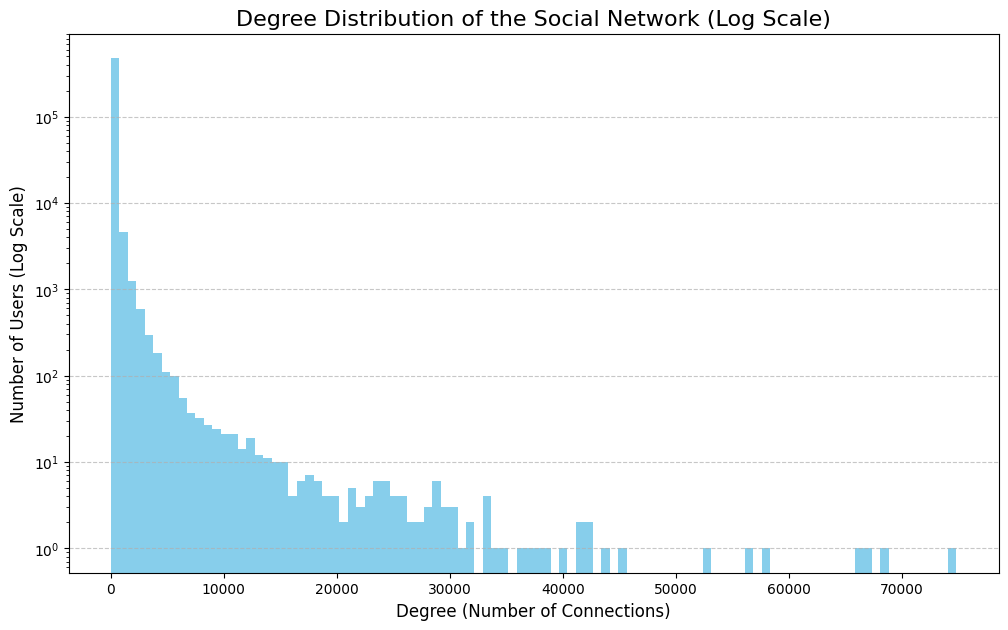

------------------------------
Step 7: Visualizing the largest community (ID: 6)...
-> Largest community has 157,643 members.
-> Community is too large to draw clearly. A random sample of 200 nodes will be visualized.
-> Community graph saved to 'results/largest_community_graph.png'


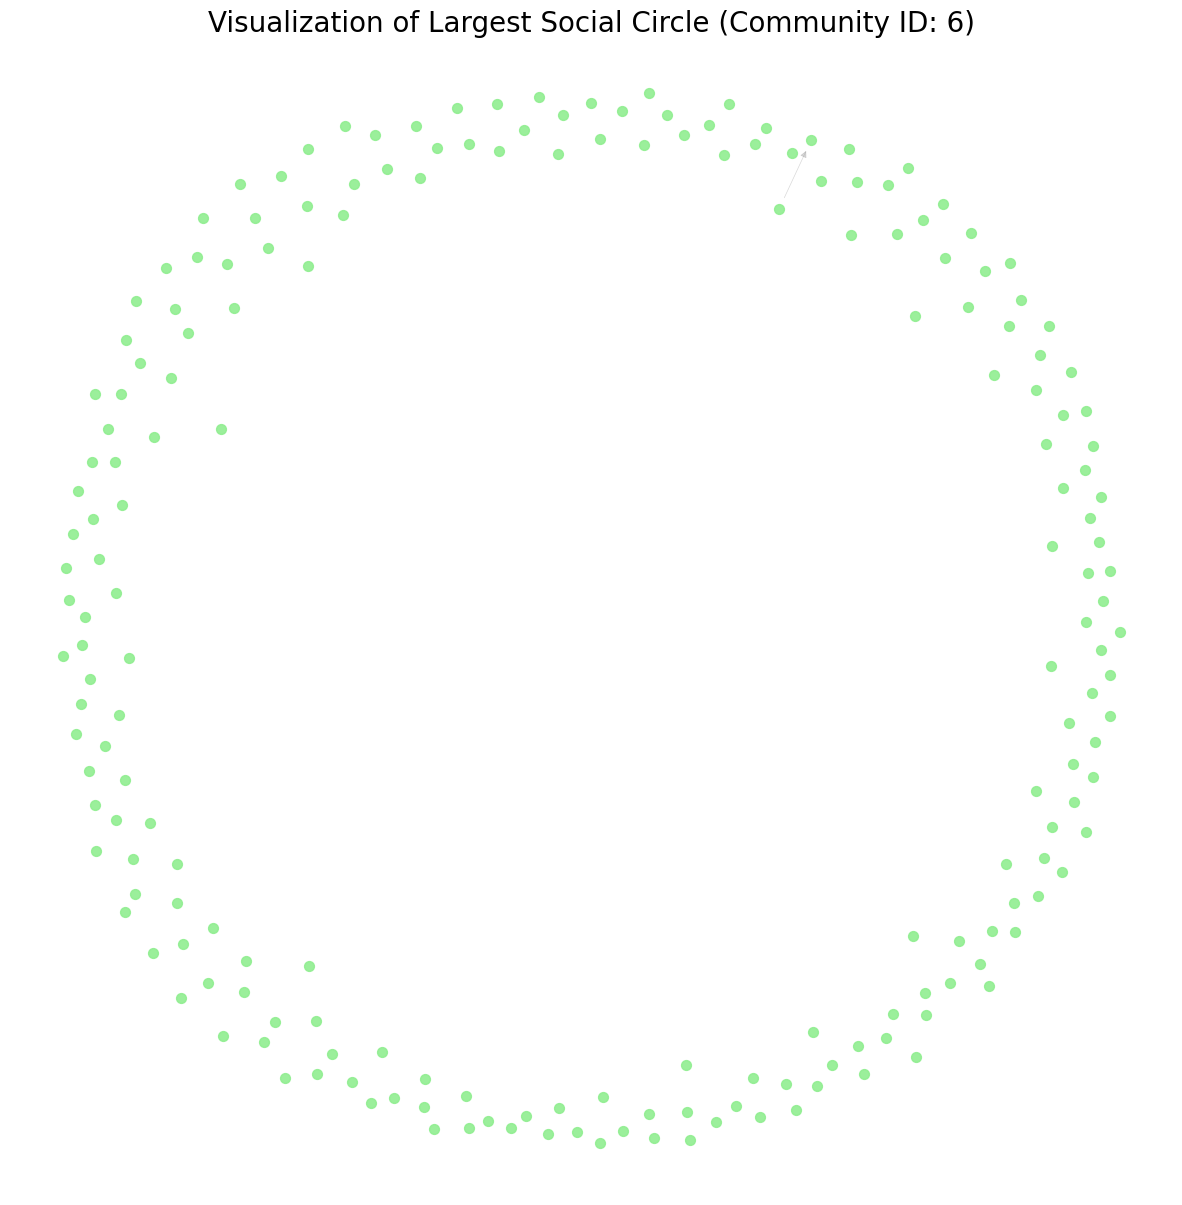

------------------------------
✅ Analysis complete!


In [3]:


# Create the graph from the 'following' edgelist
G = nx.from_pandas_edgelist(following, source='FollowerID', target='FollowedID', create_using=nx.DiGraph())
print(f"-> Graph created successfully.")
print(f"-> Nodes (Users): {G.number_of_nodes():,}")
print(f"-> Edges (Connections): {G.number_of_edges():,}")
print("-" * 30)

# --- 2. Detect Communities with Louvain Algorithm (Efficient) ---
print("Step 2: Running the Louvain algorithm...")
# The community_louvain library is highly optimized for speed.
partition = community_louvain.best_partition(G.to_undirected()) # Louvain works on undirected graphs
print("-> Community detection complete.")
print("-" * 30)

# --- 3. Analyze and Process the Results (Efficient) ---
print("Step 3: Analyzing community results...")
num_communities = len(set(partition.values()))
print(f"-> Discovered {num_communities} distinct communities.")

partition_df = pd.DataFrame(list(partition.items()), columns=['ID', 'CommunityID'])
community_sizes = partition_df['CommunityID'].value_counts().reset_index()
community_sizes.columns = ['CommunityID', 'NumberOfMembers']
print("\nTop 10 Largest Social Circles:")
print(community_sizes.head(10).to_string(index=False))
print("-" * 30)

# --- 4. Merge and Save Results (Efficient) ---
print("Step 4: Merging and saving results...")
users_with_communities = pd.merge(users, partition_df, on='ID', how='inner')
output_filepath = "results/users_with_communities.csv"
users_with_communities.to_csv(output_filepath, index=False, encoding='utf-8')
print(f"-> Successfully saved results to '{output_filepath}'")
print("-" * 30)

# --- 5. Display a Sample from the Largest Community (Efficient) ---
if not community_sizes.empty:
    largest_community_id = community_sizes.iloc[0]['CommunityID']
    print(f"Step 5: Sample of users from the largest community (ID: {largest_community_id}):")
    largest_community_members = users_with_communities[
        users_with_communities['CommunityID'] == largest_community_id
    ]
    print(largest_community_members[['ID', 'Name', 'CommunityID']].head(15).to_string(index=False))
else:
    print("No communities were found to display a sample.")
print("-" * 30)


# --- 6. Plot Degree Distribution (Efficient) ---
print("Step 6: Generating Degree Distribution Plot...")
# --- OPTIMIZATION 4: More efficient way to get degrees ---
# This avoids creating an intermediate list of nodes.
degrees = [d for n, d in G.degree()]

plt.figure(figsize=(12, 7))
plt.hist(degrees, bins=100, log=True, color='skyblue', ec='black')
plt.title('Degree Distribution of the Social Network (Log Scale)', fontsize=16)
plt.xlabel('Degree (Number of Connections)', fontsize=12)
plt.ylabel('Number of Users (Log Scale)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

degree_plot_path = 'results/degree_distribution.png'
plt.savefig(degree_plot_path)
print(f"-> Degree distribution plot saved to '{degree_plot_path}'")
plt.show()
print("-" * 30)


# --- 7. Visualize the Largest Community (Your existing efficient code) ---
# This part of your code was already well-optimized by sampling!
print(f"Step 7: Visualizing the largest community (ID: {largest_community_id})...")

nodes_in_community = [
    n for n, c_id in partition.items() if c_id == largest_community_id
]
subgraph = G.subgraph(nodes_in_community)
print(f"-> Largest community has {subgraph.number_of_nodes():,} members.")

if subgraph.number_of_nodes() > 200:
    print("-> Community is too large to draw clearly. A random sample of 200 nodes will be visualized.")
    sampled_nodes = pd.Series(list(subgraph.nodes())).sample(200, random_state=42).tolist()
    vis_subgraph = subgraph.subgraph(sampled_nodes)
else:
    vis_subgraph = subgraph

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(vis_subgraph, seed=42, k=0.15)
nx.draw_networkx_nodes(vis_subgraph, pos, node_size=50, node_color='lightgreen', alpha=0.9)
nx.draw_networkx_edges(vis_subgraph, pos, width=0.5, alpha=0.3, edge_color='gray')
plt.title(f'Visualization of Largest Social Circle (Community ID: {largest_community_id})', fontsize=20)
plt.axis('off')

community_plot_path = 'results/largest_community_graph.png'
plt.savefig(community_plot_path)
print(f"-> Community graph saved to '{community_plot_path}'")
plt.show()
print("-" * 30)
print("✅ Analysis complete!")

In [5]:
import pandas as pd

# Assume the following dataframes are already loaded and populated:
# users_with_communities, following, entries, likes, comments

TOP_N_COMMUNITIES = 10

def print_excel_row(description, data_series):
    """
    Calculates key statistics for a pandas Series and prints them
    as a single, tab-separated row for easy pasting into a spreadsheet.
    """
    if data_series.empty or data_series.isnull().all():
        # If no data, print the description followed by zero-value placeholders
        print(f"{description}\t0.00\t0\t0.00\t0")
        return

    # Calculate statistics
    avg = data_series.mean()
    median = data_series.median()
    # Ensure std deviation is 0 if there's only one data point (to avoid NaN)
    std_dev = data_series.std()
    std_dev = 0 if pd.isna(std_dev) else std_dev
    max_val = data_series.max()

    # Print the formatted, tab-separated string
    # The median and max are formatted as integers to match your screenshot
    print(f"{description}\t{avg:.2f}\t{int(median)}\t{std_dev:.2f}\t{int(max_val)}")

# --- Main Analysis Loop ---

top_communities = users_with_communities['CommunityID'].value_counts().nlargest(TOP_N_COMMUNITIES).index

for community_id in top_communities:
    print(f"\n\n# --- Statistics for Community ID: {community_id} ---")
    print("# Copy the block below and paste it into Excel")
    # Print the header row for the spreadsheet
    print("Type\tAverage\tMedian\tStandard Deviation\tMaximum")

    # 1. Get all user IDs for the current community
    community_members = users_with_communities[users_with_communities['CommunityID'] == community_id]['ID']

    # 2. Filter the main dataframes for members of this community
    following_c = following[following['FollowerID'].isin(community_members) | following['FollowedID'].isin(community_members)]
    entries_c = entries[entries['PostedBy'].isin(community_members)]
    likes_c = likes[likes['userID'].isin(community_members)]
    comments_c = comments[comments['PostedBy'].isin(community_members)]

    # --- Follower Count per User ---
    follower_count = following_c[following_c['FollowedID'].isin(community_members)]['FollowedID'].value_counts()
    print_excel_row("Follower Count per User", follower_count)

    # --- Following Count per User ---
    following_count = following_c[following_c['FollowerID'].isin(community_members)]['FollowerID'].value_counts()
    print_excel_row("Following Count per User", following_count)

    # --- Posts Created per User ---
    posts_created = entries_c['PostedBy'].value_counts()
    print_excel_row("Posts Created per User", posts_created)

    # --- Likes Received per Post per User ---
    if not entries_c.empty:
        likes_per_post = likes.groupby('PostID').size().rename('LikesCount')
        posts_with_likes = entries_c.merge(likes_per_post, on='PostID', how='left').fillna(0)
        avg_likes_received = posts_with_likes.groupby('PostedBy')['LikesCount'].mean()
        print_excel_row("Likes Received per Post per User", avg_likes_received)
    else:
        print_excel_row("Likes Received per Post per User", pd.Series(dtype='float64'))

    # --- Likes Given per User ---
    likes_given = likes_c['userID'].value_counts()
    print_excel_row("Likes Given per User", likes_given)

    # --- Comments Received per Post per User ---
    if not entries_c.empty:
        comments_per_post = comments.groupby('PostID').size().rename('CommentsCount')
        posts_with_comments = entries_c.merge(comments_per_post, on='PostID', how='left').fillna(0)
        avg_comments_received = posts_with_comments.groupby('PostedBy')['CommentsCount'].mean()
        print_excel_row("Comments Received per Post per User", avg_comments_received)
    else:
        print_excel_row("Comments Received per Post per User", pd.Series(dtype='float64'))

    # --- Comments Given per User ---
    comments_given = comments_c['PostedBy'].value_counts()
    print_excel_row("Comments Given per User", comments_given)



# --- Statistics for Community ID: 6 ---
# Copy the block below and paste it into Excel
Type	Average	Median	Standard Deviation	Maximum
Follower Count per User	109.66	36	491.91	42487
Following Count per User	38.76	4	570.49	58349
Posts Created per User	31.86	8	191.34	22375
Likes Received per Post per User	0.01	0	0.13	16
Likes Given per User	33.95	2	165.45	3948
Comments Received per Post per User	0.07	0	0.34	34
Comments Given per User	24.76	3	138.02	4365


# --- Statistics for Community ID: 1 ---
# Copy the block below and paste it into Excel
Type	Average	Median	Standard Deviation	Maximum
Follower Count per User	44.16	12	364.06	36765
Following Count per User	25.48	3	681.91	73103
Posts Created per User	59.50	9	326.26	16258
Likes Received per Post per User	0.00	0	0.06	5
Likes Given per User	9.65	1	43.66	666
Comments Received per Post per User	0.05	0	0.21	14
Comments Given per User	48.15	3	307.91	12197


# --- Statistics for Community ID: 0 ---
# Copy the block below and paste it into Exce